# Reinforcement Learning

### Deep Contextual Multi Armed Bandits

This notebook builds out one of the example problems (Section 4.1 - The Mushroom Task) from the following paper. 

https://arxiv.org/pdf/1807.09809.pdf

Before reading this paper, it will helpful to be familiar with Thompson Sampling, a method for solving a multi-armed bandit style problem.

From the previous paper:

> "Thomson sampling [27] is a heuristic for trading off exploration and exploitation when using a parametric likelihood 
$P(r | a,x,w)$ function and a posterior on the parameters $P(w | {x,a,r})$. At each timestep we sample
$w ~= P(w | {x,a,r})$ and then choose the action with highest expected reward $P(r | a,x,w)$. Thompson sampling has been shown to be a very effective heuristic for managing this trade-off [1, 10].

https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

#### The Mushroom Task Dataset

This is a UCI dataset with several categorical variables describing mushrooms. The target variable is a binary 0/1 meaning poisonous or safe to eat.

Here is a link to the dataset: https://archive.ics.uci.edu/ml/datasets/mushroom

Let's read in the data and create dummy variables for all of the features.

In [1]:
import pandas as pd
import random
from copy import deepcopy
import scipy
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from ConcreteDropout import *

df = pd.read_csv('mushroom_dataset.csv',header=None)

# 1 for safe, 0 for poisonous
df['target'] = 0
df.loc[df[0] == 'e', 'target'] = 1
df = df.drop(0,axis=1)
df = pd.get_dummies(df)

Using TensorFlow backend.


In [2]:
df.head()

,target,1_b,1_c,1_f,1_k,1_s,1_x,2_f,2_g,2_s,...,21_s,21_v,21_y,22_d,22_g,22_l,22_m,22_p,22_u,22_w
0,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


Now, let's set up the reinforcement learning problem. The authors suggest the following model architecture.

>In our model, we use a neural network to model $P(r | a,x,w)$, where w are the network weights.
At each timestep we are presented with a context x and a set of possible actions {a1, a2, ..., am}. We sample
dropout noise d from a uniform distribution, which is used to, in effect, sample from the posterior
over the weights w. We unroll the m actions into (x,a) pairs which are passed to the network for inference.
We choose the action a whose (x, ai) pair has the highest expected reward.

>In the below experiments for the contextual models (including the epsilon-greedy and fixed dropout rate bandits), we use a neural network with 2 hidden layers with
256 units each and ReLU activation function. All networks are trained using the Adam optimizer [17] with
initial learning rate = 0.001.


After choosing the action with the highest expected reward, we update our model via gradient descent.


A novel proposal suggested by the authors is to use dropout as a way to sample from the posterior distribution of the expected reward function.

>Of particular importance to our application is a recent result [12] where dropout training [26] in an arbitrary
depth feed-forward neural network with arbitrary nonlinearities is shown to be equivalent to an approximation
of the probabilistic deep Gaussian process [11]. In practice this Bayesian interpretation of dropout means that if
we turn dropout on at inference time, each stochastic forward pass through the network corresponds to a sample
from an approximate posterior over the network weights.This property of dropout at inference time has been used
to undertake Thompson sampling to drive exploration in reinforcement learning problems [12].

Further, instead of using a static dropout probability, the authors propose using Concrete Dropout.

>Under the Bayesian interpretation of dropout, a continuous relaxation of Bernoulli dropout using the Concrete
distribution [22] can be realized [13]. This continuous relaxation of dropout, named Concrete Dropout, treats the
dropout parameter p (the probability of turning off a node
in Bernoulli dropout) as a parameter of the network that
can be trained using standard gradient descent methods.
Appropriate regularization parameters are then added to
the objective function, which trades off between fitting
the data and maximizing the entropy of the dropout parameter. As the amount of data increases, the data likelihood term overwhelms the dropout regularization term,
which leads to well calibrated uncertainty estimates, and
thus appropriate levels of exploration.

Read the original paper on Concrete Dropout here: https://pdfs.semanticscholar.org/452a/c69a8af5366778f3be178966433f2b6bf70a.pdf?_ga=2.80494167.1719340469.1565904110-2090621344.1565904110

Here is the Keras implementation by one of the authors: https://github.com/yaringal/ConcreteDropout/blob/master/concrete-dropout-keras.ipynb

Now, let's move on to the reinforcement learning task.

### The Mushroom Task

>At each timestep, our agent is presented with the
features for a mushroom and must decide whether to eat
it or not. The agent gets a reward of 1 for eating an
edible mushroom, a reward of 0 for eating a poisonous
mushroom, and with probability p a reward of 1 for not
eating a mushroom. In the below experiments we set
p = 0.5.

The inputs to the model are all mushroom features, plus one additional binary 'action' feaure. This action feature is the action chosen by the agent - either to eat or not eat the mushroom. We create two records with the same mushroom features, but different action features. We score both records using the model, and choose the record that has the highest score.

After observing the reward, the model weights are updated via gradient descent. We do this for thousands of timesteps.

In [3]:
from tqdm import tqdm
#Create model structure
model = Sequential()
model.add(Dense(256, input_dim=118, activation='relu'))
model.add(ConcreteDropout(Dense(256, activation='relu')))
model.add(ConcreteDropout(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam')

steps = 50000

rewards = [0 for i in range(steps)]
oracle = [0 for i in range(steps)]
ps = [0 for i in range(steps)]

for i in tqdm(range(steps)):
    # Sample a random mushroom
    u = df.iloc[[i % df.shape[0]]]
    t = u['target']
    u = u.drop('target',axis='columns')
    v = deepcopy(u)
    
    # One record for eat, one record for don't eat
    u['action'] = 1
    v['action'] = 0
    
    # Score both actions
    a = model.predict(u.values)
    b = model.predict(v.values)
    
    # Choose action w/ higher expected reward
    results = pd.DataFrame()

    ran = random.uniform(0,1)
    
    # if safe
    if t.values[0] == 1:
        oracle[i] = 1
        
        #if eat
        if a >= b:
            u['reward'] = 1
            rewards[i] = 1
            results = pd.concat([results,u])

        #dont eat
        elif b > a:
            if ran > .5:
                rewards[i] = 1
                v['reward'] = 1
            else:
                v['reward'] = 0
            results = pd.concat([results,v])
               
    # if poisonous
    elif t.values[0] == 0:
        if ran > .5:
            oracle[i] = 1
        #if eat
        if a >= b:
            u['reward'] = 0
            results = pd.concat([results,u])

        #dont eat
        elif b > a:
            if ran > .5:
                rewards[i] = 1
                v['reward'] = 1
            else:
                v['reward'] = 0
            
            results = pd.concat([results,v])
    

    y = results.reward
    X = results.drop('reward',axis='columns')
    model.fit(X.values,y.values,verbose=False)
    
    weights, biases, p = model.layers[1].get_weights()
    ps[i] = scipy.special.expit(p)

W0909 16:11:35.519476  9188 deprecation_wrapper.py:119] From C:\Users\u365296\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 16:11:35.544583  9188 deprecation_wrapper.py:119] From C:\Users\u365296\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 16:11:35.548602  9188 deprecation_wrapper.py:119] From C:\Users\u365296\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 16:11:35.594756  9188 deprecation_wrapper.py:119] From C:\Users\u365296\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.lo

We can observe the cumulative 'regret', or difference between the actions of our agent and those of an omniscient 'oracle' who always make the correct choice (i.e. eating a safe mushroom, not eating a poisonous mushroom).

This curve will flatten out over time as the agent becomes proficient at choosing the correct action.

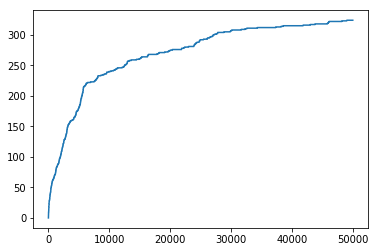

In [4]:
cumulative_reward = pd.Series(rewards).cumsum()
oracle_reward = pd.Series(oracle).cumsum()
cumulative_regret = oracle_reward - cumulative_reward

# Regret is the difference in reward between chosen action and perfect 'oracle'
import seaborn as sns
sns.lineplot(x=range(steps),y=cumulative_regret)

The dropout probability will become smaller as the model observes more data and becomes more confident.

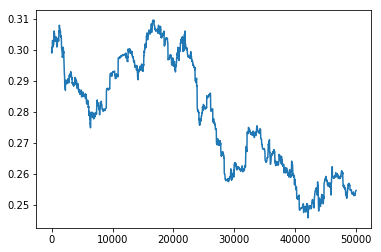

In [5]:
# The dropout probabality decreases as the model becomes more confident
pss = [x[0] for x in ps]
sns.lineplot(x=range(steps),y=pss)